In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
# from InceptionTimeModel import *
from SimpleCNN import SimpleCNN

--- Processing Intra-subject Training Data (with Validation Split) ---
Loading H5 data from data/Intra/train...
Applying decimation (factor 4) to 4 loaded samples...
Applying chunking with chunk_length=3000, hop_length=1000...
Chunking complete: 4 original samples expanded/processed into 276 chunks.
Splitting data into training and validation sets (validation_split=0.1, random_state=42)...
Training set size: 248, Validation set size: 28
Loaded 248 samples/chunks into Training DataLoader from data/Intra/train.
LabelEncoder classes: ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
Loaded 28 samples/chunks into Validation DataLoader from data/Intra/train.
Effective params: (original_downsample_factor=4, chunk_length=3000, hop_length=1000, normalize=True, validation_split=0.1).
Intra-subject training DataLoader created. Label mapping: {'rest': 0, 'task_motor': 1, 'task_story_math': 2, 'task_working_memory': 3}
Intra-subject validation DataLoader created.

--- Processing Int

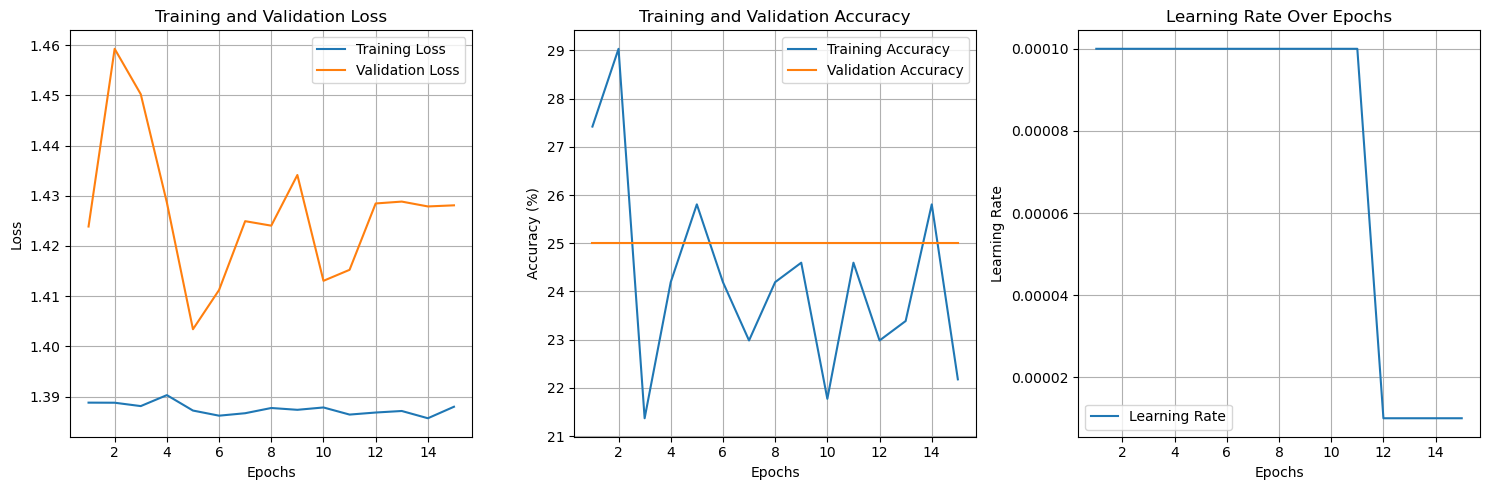


--- Evaluating on Test Set ---
Test Accuracy: 25.00%

Script finished.


In [3]:
from data_utils import prepare_pytorch_dataloader
# from InceptionTimeModel import InceptionTime, train_model, plot_training_history
from train_utils import train_model, plot_training_history
import torch
import numpy as np

if __name__ == '__main__':
    # Hyperparameters
    # Data paths
    intra_train_path = 'data/Intra/train'
    intra_test_path = 'data/Intra/test'
    
    # Data processing parameters
    DOWNSAMPLE_FACTOR = 4 # Consistent downsample factor for both train and test
    CHUNK_LENGTH = 3000
    HOP_LENGTH = 1000
    NORMALIZE = True
    TRAIN_BATCH_SIZE = 16
    TEST_BATCH_SIZE = 16
    VALIDATION_SPLIT = 0.1
    RANDOM_SEED = 42
    NOISE_STD = 0.05
    SCALE_RANGE = (0.9, 1.1)
    
    # Model parameters
    IN_CHANNELS = 248
    
    # Training parameters
    EPOCHS = 50
    LEARNING_RATE = 0.0001
    PATIENCE = 10
    LR_PATIENCE = 5
    LR_FACTOR = 0.1
    
    le_intra = None

    print("--- Processing Intra-subject Training Data (with Validation Split) ---")
    train_loader_intra, val_loader_intra, le_intra = prepare_pytorch_dataloader(
        intra_train_path, 
        batch_size=TRAIN_BATCH_SIZE, 
        shuffle_train=True, 
        num_workers=0, 
        downsample_factor=DOWNSAMPLE_FACTOR, 
        chunk_length=CHUNK_LENGTH, 
        hop_length=HOP_LENGTH, 
        normalize=NORMALIZE,
        validation_split=VALIDATION_SPLIT, 
        random_state=RANDOM_SEED,
        augment_noise_std_train=NOISE_STD,
        augment_scale_range_train=SCALE_RANGE
    )
    
    if train_loader_intra and le_intra: 
        print(f"Intra-subject training DataLoader created. Label mapping: {dict(zip(le_intra.classes_, le_intra.transform(le_intra.classes_)))}")
        if val_loader_intra:
            print("Intra-subject validation DataLoader created.")
        else:
            print("Intra-subject validation DataLoader was NOT created (check split or data).")
    elif not train_loader_intra:
        print("Failed to create Intra-subject training DataLoader. Exiting.")
        exit()

    print("\n--- Processing Intra-subject Test Data ---")
    test_loader_intra = None
    if le_intra: 
        test_loader_intra, _, _ = prepare_pytorch_dataloader(
            intra_test_path, 
            batch_size=TEST_BATCH_SIZE, 
            shuffle_train=False, 
            label_encoder=le_intra, 
            num_workers=0, 
            downsample_factor=DOWNSAMPLE_FACTOR,
            chunk_length=CHUNK_LENGTH,
            hop_length=HOP_LENGTH,
            normalize=NORMALIZE,
            validation_split=None
        )
        if test_loader_intra:
            print("Intra-subject test DataLoader created.")
        else:
            print("Failed to create Intra-subject test DataLoader (possibly due to label issues or no data).")
    else:
        print("Skipping Intra-subject test data processing as training label encoder is missing.")

    # Set random seed for reproducibility
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    # Set device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    # Determine number of classes from the label encoder
    if le_intra:
        num_classes = len(le_intra.classes_)
        print(f"Number of classes determined from label encoder: {num_classes}")
    else:
        print("Error: Label encoder not available. Cannot determine number of classes. Exiting.")
        exit()





# MODEL ----
    model = SimpleCNN(
        in_channels=IN_CHANNELS,
        kernel_sizes_extra=[3, 5, 7, 9, 11],
        intermediate_channels=64,
        n_classes=num_classes, 
    ).to(device)





    print("\nModel Architecture:")
    print(model)

    print("\n--- Training Model ---")
    if train_loader_intra and val_loader_intra:
        model, history = train_model(
            model=model,
            train_loader=train_loader_intra, 
            val_loader=val_loader_intra,
            epochs=EPOCHS,
            lr=LEARNING_RATE,
            patience=PATIENCE,
            lr_patience=LR_PATIENCE,
            lr_factor=LR_FACTOR
        )
        
        print("\n--- Plotting Training History ---")
        plot_training_history(history)
    else:
        print("Skipping model training as training or validation data loader is missing.")
        exit()

    print("\n--- Evaluating on Test Set ---")
    if test_loader_intra:
        model.eval()
        total_test_samples = 0
        correct_test_predictions = 0

        with torch.no_grad():
            for test_X_batch, test_y_batch in test_loader_intra: 
                test_X_batch = test_X_batch.to(device)
                test_y_batch = test_y_batch.to(device)
                outputs = model(test_X_batch)
                _, predicted = torch.max(outputs, 1)
                total_test_samples += test_y_batch.size(0)
                correct_test_predictions += (predicted == test_y_batch).sum().item()

        if total_test_samples > 0:
            accuracy = 100 * correct_test_predictions / total_test_samples
            print(f'Test Accuracy: {accuracy:.2f}%')
        else:
            print("No samples in the test set to evaluate.")
    else:
        print("Skipping test set evaluation as test data loader is missing.")

    print("\nScript finished.")

--- Processing Intra-subject Training Data ---
Loading H5 data from data/Intra/train...
Applying decimation (factor 4) to 4 loaded samples...
Applying chunking with chunk_length=3000, hop_length=1000...
Chunking complete: 4 original samples expanded/processed into 276 chunks.
Fitting new LabelEncoder on training data.
Fitted LabelEncoder. Classes: ['rest' 'task_motor' 'task_story_math' 'task_working_memory'] -> [0 1 2 3]
Loaded 276 samples/chunks into Training DataLoader from data/Intra/train.
LabelEncoder classes used for training: ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
Effective params: (original_downsample_factor=4, chunk_length=3000, hop_length=1000, normalize=True, validation_split=None).
Intra-subject training DataLoader created. Label mapping: {'rest': 0, 'task_motor': 1, 'task_story_math': 2, 'task_working_memory': 3}

--- Processing Intra-subject Test Data (for validation) ---
Loading H5 data from data/Intra/test...
Applying decimation (factor 4) to 4

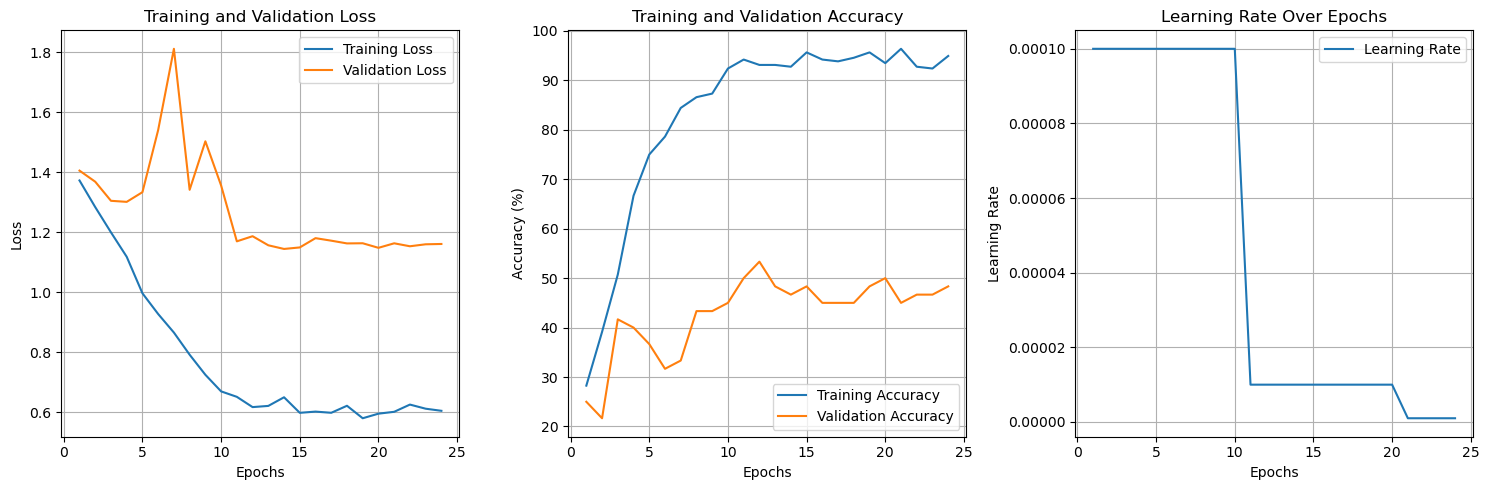


--- Final Evaluation on Validation Set ---
Final Validation Accuracy: 48.33%

Script finished.


In [19]:
from data_utils import prepare_pytorch_dataloader
from InceptionTimeModel import InceptionTime, train_model, plot_training_history
import torch
import numpy as np

if __name__ == '__main__':
    # Hyperparameters
    # Data paths
    intra_train_path = 'data/Intra/train'
    intra_test_path = 'data/Intra/test'
    
    # Data processing parameters
    DOWNSAMPLE_FACTOR = 4 # Consistent downsample factor for both train and test
    CHUNK_LENGTH = 3000
    HOP_LENGTH = 1000
    NORMALIZE = True
    TRAIN_BATCH_SIZE = 16
    TEST_BATCH_SIZE = 32
    RANDOM_SEED = 42
    NOISE_STD = 0.05
    SCALE_RANGE = (0.9, 1.1)
    
    # Model parameters
    IN_CHANNELS = 248
    N_FILTERS = 16
    N_BLOCKS = 1
    BOTTLENECK_CHANNELS = 32
    
    # Training parameters
    EPOCHS = 50
    LEARNING_RATE = 0.0001
    PATIENCE = 10
    LR_PATIENCE = 5
    LR_FACTOR = 0.1
    
    le_intra = None

    print("--- Processing Intra-subject Training Data ---")
    train_loader_intra, _, le_intra = prepare_pytorch_dataloader(
        intra_train_path, 
        batch_size=TRAIN_BATCH_SIZE, 
        shuffle_train=True, 
        num_workers=0, 
        downsample_factor=DOWNSAMPLE_FACTOR, 
        chunk_length=CHUNK_LENGTH, 
        hop_length=HOP_LENGTH, 
        normalize=NORMALIZE,
        validation_split=None,  # No validation split from training data
        random_state=RANDOM_SEED,
        augment_noise_std_train=NOISE_STD,
        augment_scale_range_train=SCALE_RANGE
    )
    
    if train_loader_intra and le_intra: 
        print(f"Intra-subject training DataLoader created. Label mapping: {dict(zip(le_intra.classes_, le_intra.transform(le_intra.classes_)))}")
    elif not train_loader_intra:
        print("Failed to create Intra-subject training DataLoader. Exiting.")
        exit()

    print("\n--- Processing Intra-subject Test Data (for validation) ---")
    val_loader_intra = None
    if le_intra: 
        val_loader_intra, _, _ = prepare_pytorch_dataloader(
            intra_test_path, 
            batch_size=TEST_BATCH_SIZE, 
            shuffle_train=False, 
            label_encoder=le_intra, 
            num_workers=0, 
            downsample_factor=DOWNSAMPLE_FACTOR,
            chunk_length=CHUNK_LENGTH,
            hop_length=HOP_LENGTH,
            normalize=NORMALIZE,
            validation_split=None
        )
        if val_loader_intra:
            print("Intra-subject validation DataLoader created from test set.")
        else:
            print("Failed to create Intra-subject validation DataLoader (possibly due to label issues or no data).")
    else:
        print("Skipping Intra-subject validation data processing as training label encoder is missing.")

    # Set random seed for reproducibility
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    # Set device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    # Determine number of classes from the label encoder
    if le_intra:
        num_classes = len(le_intra.classes_)
        print(f"Number of classes determined from label encoder: {num_classes}")
    else:
        print("Error: Label encoder not available. Cannot determine number of classes. Exiting.")
        exit()

    model = InceptionTime(
        in_channels=IN_CHANNELS,
        n_classes=num_classes, 
        n_filters=N_FILTERS,
        n_blocks=N_BLOCKS,   
        bottleneck_channels=BOTTLENECK_CHANNELS
    ).to(device)

    print("\nModel Architecture:")
    print(model)

    print("\n--- Training Model ---")
    if train_loader_intra and val_loader_intra:
        model, history = train_model(
            model=model,
            train_loader=train_loader_intra, 
            val_loader=val_loader_intra,  # Using test set as validation
            epochs=EPOCHS,
            lr=LEARNING_RATE,
            patience=PATIENCE,
            lr_patience=LR_PATIENCE,
            lr_factor=LR_FACTOR
        )
        
        print("\n--- Plotting Training History ---")
        plot_training_history(history)
    else:
        print("Skipping model training as training or validation data loader is missing.")
        exit()

    print("\n--- Final Evaluation on Validation Set ---")
    if val_loader_intra:
        model.eval()
        total_val_samples = 0
        correct_val_predictions = 0

        with torch.no_grad():
            for val_X_batch, val_y_batch in val_loader_intra: 
                val_X_batch = val_X_batch.to(device)
                val_y_batch = val_y_batch.to(device)
                outputs = model(val_X_batch)
                _, predicted = torch.max(outputs, 1)
                total_val_samples += val_y_batch.size(0)
                correct_val_predictions += (predicted == val_y_batch).sum().item()

        if total_val_samples > 0:
            accuracy = 100 * correct_val_predictions / total_val_samples
            print(f'Final Validation Accuracy: {accuracy:.2f}%')
        else:
            print("No samples in the validation set to evaluate.")
    else:
        print("Skipping final evaluation as validation data loader is missing.")

    print("\nScript finished.")